In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.clip_grad import clip_grad_norm_
import torch.distributions as distributions

import matplotlib.pyplot as plt

import numpy as np

import datetime
import itertools

from torch.utils.tensorboard import SummaryWriter

from collections import namedtuple, deque
import random

import gym

In [126]:
env = gym.make("CartPole-v1")

In [127]:
class DQNetwork(nn.Module):
    """
    Neural network that acts as a function approximator for Q learning. 
    """
    def __init__(self, n_input, n_actions):
        """
        Initialize parameters nad build the model
        
        Parameters
        ----------
            input_shape: the dimensions of of the statespce in the form of (n, batch_n)
            n_actions: available actions in the environments action space
            
        """
        super(DQNetwork, self).__init__()
        
        self.l1 = nn.Linear(n_input, 12)
        self.l2 = nn.Linear(12, 12)
        self.l3 = nn.Linear(12, n_actions)
        
    def forward(self, state):
        state = F.relu(self.l1(state))
        state = F.relu(self.l2(state))

        return self.l3(state)
  

In [128]:
class ReplayMemory:
    """
    Fixed -size buffe to store experience tuples.
    
    Parameters
    ----------
    action_size: int 
        Environment's action space
    buffer_size: int 
        Maximum size of buffer
    batch_size: int S
        Size of each training batch

    """
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.experiences = namedtuple("Experience", field_names=["state",
                                                                "action",
                                                                "reward",
                                                                "next_state",
                                                                "done"])
        self.batch_size = batch_size

    def push(self,state, action, reward, next_state,done):
        """
        Adds an observation to the replay buffer
        
        Parameters
        ----------
        state: ndarray
            Array containing state representation at current timestep
        action: int
            Action chosen at current timestep
        reward: int
            Reward received at current timestep
        next_state: ndarray
            Array containing state representation at next timestep
        done: bool
            Flag indicator whether current state is terminal
            
        """
        e = self.experiences(state, action, reward, next_state,done)
        self.memory.append(e)

    def sample(self, batch_size):
        """
        Randomly sample a batch of observations from memory
        """
        
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).int()
        
        return states, actions, rewards, next_states, dones
        
    def __len__(self):
        return len(self.memory)

In [129]:

class Agent():
    """
    Interacts with and learns form environment. 
    """
    def __init__(self, state_size, action_size):
        """
        Initializes agent
        
        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed 
        
        """
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.qnetwork_online = DQNetwork(state_size, action_size)
        self.qnetwork_target = DQNetwork(state_size, action_size)
        
        self.optimizer = optim.Adam(self.qnetwork_online.parameters(), lr = LR)
        
        self.memory = ReplayMemory(action_size, BUFFER_SIZE, BATCH_SIZE)
        
        # Target network update timestep counter
        self.t_step = 0
        
    def take_action(self, state, epsilon = 0.9):
        """
        Takes an action according to the followed policy
        
        Params
        =====
            state (array): current state 
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            values = self.qnetwork_online(state).squeeze()
            action = values.argmax().item()
            
        if np.random.rand() < epsilon:
            action = random.choice(np.arange(self.action_size))
            
        return action
    
    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)  
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        loss = 0
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                loss = self.learn(GAMMA)   
        return loss     
    
    def learn(self, GAMMA):
        states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = self.memory.sample(BATCH_SIZE)
        
        self.qnetwork_online.train()
        self.qnetwork_target.eval()
        
        q_values = self.qnetwork_online(states_batch)
        q_values = q_values.gather(1, actions_batch)
        
        with torch.no_grad():          
            max_next_Q = self.qnetwork_target(next_states_batch).max(dim = 1)[0].unsqueeze(1)
        
        td_target = rewards_batch + (GAMMA * max_next_Q * (1-dones_batch))
        
        criterion = nn.MSELoss()
        
        self.optimizer.zero_grad()
        

        loss = criterion(q_values, td_target)
        
        loss.backward()
        
        self.optimizer.step()
        
        self.soft_update(TAU)
        
        return loss.item()
        
    def soft_update(self, tau):
        for target_param, local_param in zip(self.qnetwork_target.parameters(),
                                           self.qnetwork_online.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
                                     
                                    
    

In [262]:
class DQNetwork(nn.Module):
    """
    Neural network that acts as a function approximator for Q learning. 
    """
    def __init__(self, n_input, n_actions):
        """
        Initialize parameters nad build the model
        
        Params
        =========
            input_shape: the dimensions of of the statespce in the form of (n, batch_n)
            n_actions: available actions in the environments action space
            
        """
        super(DQNetwork, self).__init__()
        
        self.l1 = nn.Linear(n_input, 32)
        self.l2 = nn.Linear(32, 16)
        self.l3 = nn.Linear(16, n_actions)
        
    def forward(self, state):
        state = F.relu(self.l1(state))
        state = F.relu(self.l2(state))

        return self.l3(state)

class ReplayMemory:
    """
    Fixed -size buffe to store experience tuples.
    
    Params
    ======
        action_size (int): dimension of each action
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch

    """
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.experiences = namedtuple("Experience", field_names=["state",
                                                                "action",
                                                                "reward",
                                                                "next_state",
                                                                "done"])
        self.batch_size = batch_size

    def push(self,state, action, reward, next_state,done):
        """
        Adds an observation to the replay buffer
        """
        e = self.experiences(state, action, reward, next_state,done)
        self.memory.append(e)

    def sample(self, batch_size):
        """
        Randomly sample a batch of observations from memory
        """
        
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).int()
        
        return states, actions, rewards, next_states, dones
        
    def __len__(self):
        return len(self.memory)
    

class Agent():
    """
    Interacts with and learns form environment. 
    """
    def __init__(self, state_size, action_size):
        """
        Initializes agent
        
        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed 
        
        """
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.qnetwork_online = DQNetwork(state_size, action_size)
        self.qnetwork_target = DQNetwork(state_size, action_size)
        
        self.optimizer = optim.Adam(self.qnetwork_online.parameters(), lr = LR)
        
        self.memory = ReplayMemory(action_size, BUFFER_SIZE, BATCH_SIZE)
        
        # Target network update timestep counter
        self.t_step = 0
        
    def take_action(self, state, epsilon):
        """
        Takes an action according to the followed policy
        
        Params
        =====
            state (array): current state 
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            values = self.qnetwork_online(state).squeeze()
            action = values.argmax().item()
            
        if np.random.rand() < epsilon:
            action = random.choice(np.arange(self.action_size))
            
        return action
    
    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)  
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        loss = 0
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                loss = self.learn(GAMMA)   
        return loss     
    
    def learn(self, GAMMA):
        states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = self.memory.sample(BATCH_SIZE)
        
        self.qnetwork_online.train()
        self.qnetwork_target.eval()
        
        q_values = self.qnetwork_online(states_batch)
        q_values = q_values.gather(1, actions_batch)
        
        with torch.no_grad():          
            max_next_Q = self.qnetwork_target(next_states_batch).max(dim = 1)[0].unsqueeze(1)
        
        td_target = rewards_batch + (GAMMA * max_next_Q * (1-dones_batch))
        
        criterion = nn.MSELoss()
        
        self.optimizer.zero_grad()
        

        loss = criterion(q_values, td_target)
        
        loss.backward()
        
        self.optimizer.step()
        
        self.soft_update(TAU)
        
        return loss.item()
        
    def soft_update(self, tau):
        for target_param, local_param in zip(self.qnetwork_target.parameters(),
                                           self.qnetwork_online.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
                                     
                                    
BUFFER_SIZE = int(1e5)  #replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99           # discount factor
TAU = 0.05           # for soft update of target parameters
LR = 0.005              # learning rate
UPDATE_EVERY = 8        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make("CartPole-v0")

agent = Agent(env.observation_space.shape[0], env.action_space.n)
def dqn(env, agent, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.9999):
    scores = []
    scores_window = deque(maxlen=50)
    eps = eps_start
    for i in range(800+1):
        state = env.reset()
        score = 0  
        for t in itertools.count():
            action = agent.take_action(state, eps)
            next_state, reward, done, _ = env.step(action)
            loss = agent.step(state, action, reward, next_state, done)
            score += reward
            
            state = next_state
            
            scores_window.append(score)                    
            eps = max(eps_end, eps * eps_decay)
            if done:      
                scores.append(score)
                if i %100==99:
                    print(f'\rEpisode {i+1}\tAverage Score {np.mean(scores[-100:])}')
                break          
                
        if np.mean(scores[-100:]) >= 195:
            print(f"Environment solved! It took {i} episodes to get an average reward of {np.mean(scores[-100:])}")
            break
              
    return scores

scores = dqn(env, agent)

Episode 100	Average Score 21.47
Episode 200	Average Score 46.35
Episode 300	Average Score 181.77
Environment solved! It took 321 episodes to get an average reward of 195.65


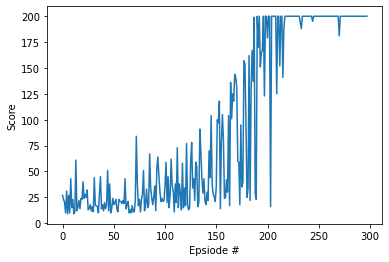

In [199]:
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score')
plt.xlabel('Epsiode #')

plt.show()

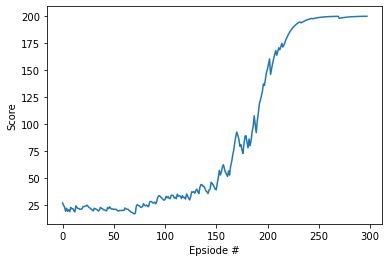

In [242]:
def moving_average(scores):
    
    moving_average = 0
    smoothed = []
    beta = 0.9
    for i in range(len(scores)):
        moving_average = (beta * moving_average + (1-beta) * scores[i])
        smoothed.append(moving_average/(1-beta**(i+1)))

    plt.plot(np.arange(len(smoothed)),smoothed)
    plt.ylabel('Score')
    plt.xlabel('Epsiode #')

    plt.show()
    
moving_average(scores)

In [274]:
obs = env.reset()
rewards = 0
done = False
while not done:
    action = agent.take_action(obs, 0)
    obs, reward, done, info = env.step(action)
    rewards += reward
print(rewards)


200.0
